In [1]:
%matplotlib inline
import rasterio
import os
import numpy as np
import subprocess
import nivapy3 as nivapy
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

plt.style.use('ggplot')

# Frisk Oslofjord: raster data processing

The raw RGB dataset is supplied as a single, 4-band (RGBA) GeoTiff with 2.2 cm cell resolution and 8-bit `uint` data type. It is located here:

     K:\Avdeling\Mar\HAN\2_Prosjekter\2019c_DRONING2019\FriskOslofjord\For ML analysis_James-Harry\2019-08-27_Flight9_RGB
     
The alpha band in this dataset provides the "no data" mask, with values of 0 corresponding to NoData and values of 255 for valid data.

The multispectral dataset is stored as separate bands here:

    K:\Avdeling\Mar\HAN\2_Prosjekter\2019c_DRONING2019\FriskOslofjord\For ML analysis_James-Harry\2019-08-27_Flight6_MS
    
These bands have a 9.3 cm cell resolution and values are stored as 32-bit `float` data type. Instead of using an "alpha mask" to represent no data, these bands use a NoData value of -10000.

Note that due to the difference in data types, values in the RGB dataset range from 0 to 255, whereas those in the multispectral data are in the range from 0 to 1. The aim of this notebook is to create a single, consistent dataset containing all the bands of interest.

## 1. Align and resample

Using a 5 cm cell resolution seems like a reasonable compromise between the two datasets. I have manually created a 5 cm "snap raster" named `bounding_box.tif`, based on a shapefile with the same name. To code below resamples and aligns all the images.

In [2]:
# Snap raster
bounding_box = '../../frisk_oslofjord/raster/bounding_box.tif'

# Multi-spectral images
flist = ['../../frisk_oslofjord/raster/multi_spec/2019-08-27_Flight6_MS_Reprocess_transparent_reflectance_blue.tif',
         '../../frisk_oslofjord/raster/multi_spec/2019-08-27_Flight6_MS_Reprocess_transparent_reflectance_green.tif', 
         '../../frisk_oslofjord/raster/multi_spec/2019-08-27_Flight6_MS_Reprocess_transparent_reflectance_red.tif', 
         '../../frisk_oslofjord/raster/multi_spec/2019-08-27_Flight6_MS_Reprocess_transparent_reflectance_nir.tif', 
         '../../frisk_oslofjord/raster/multi_spec/2019-08-27_Flight6_MS_Reprocess_transparent_reflectance_rededge.tif',
        ]

# Loop over datasets
for fpath in flist:
    name = os.path.split(fpath)[1].split('_')[-1]
    out_path = '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_' + name
    print('Processing:', out_path)
    
    # Use rio warp. See https://rasterio.readthedocs.io/en/stable/cli.html#warp
    # Syntax: rio warp input.tif output.tif --like template.tif
    args = ['rio', 
            'warp',
            fpath,
            out_path,
            '--like',
            bounding_box,
            '--overwrite',
           ]

    subprocess.check_call(args)
    
# RGB images
fpath = '../../frisk_oslofjord/raster/rgb/2019-08-27_Flight9_RGB_transparent_mosaic_group1.tif'
out_path = '../../frisk_oslofjord/raster/rgb/flight9_rgb_all.tif'
print('Processing:', out_path)

# Use rio warp. See https://rasterio.readthedocs.io/en/stable/cli.html#warp
# Syntax: rio warp input.tif output.tif --like template.tif
args = ['rio', 
        'warp',
        fpath,
        out_path,
        '--like',
        bounding_box,
        '--overwrite',
       ]

res = subprocess.check_call(args)

Processing: ../../frisk_oslofjord/raster/multi_spec/flight6_multispec_blue.tif
Processing: ../../frisk_oslofjord/raster/multi_spec/flight6_multispec_green.tif
Processing: ../../frisk_oslofjord/raster/multi_spec/flight6_multispec_red.tif
Processing: ../../frisk_oslofjord/raster/multi_spec/flight6_multispec_nir.tif
Processing: ../../frisk_oslofjord/raster/multi_spec/flight6_multispec_rededge.tif
Processing: ../../frisk_oslofjord/raster/rgb/flight9_rgb_all.tif


## 2. Extract RGB to single bands

The code here extracts each of the 4 RGB bands as a single band raster for further processing.

In [3]:
# Open multiband raster
with rasterio.open('../../frisk_oslofjord/raster/rgb/flight9_rgb_all.tif') as src:
    meta = src.meta
    nbands = src.count
    
    # Write outputs with single band
    meta.update(count=1)
    
    # Bands ordered as RGBA
    names = ['red', 'green', 'blue', 'alpha']
    
    # Loop over bands
    for idx in range(nbands):
        print('Processing:', names[idx], 'band')
        
        out_tif = f'../../frisk_oslofjord/raster/rgb/flight9_rgb_{names[idx]}.tif'
        with rasterio.open(out_tif, 'w', **meta) as dst:
            dst.write_band(1, src.read(idx+1))    

Processing: red band
Processing: green band
Processing: blue band
Processing: alpha band


## 3. Bit-depth conversion and NoData handling

To keep file sizes manageable, it seems best to work with 8-bit `unit` images (like the RGB data), rather 32-bit `float` images (like the multispectral dataset), which are four times larger. Converting from 32-bit to 8-bit involves some loss of information, which may lead to issues such as lack of "dynamic range" in the output images. However, I think 8-bit images should provide sufficient range for the ML algorithms and the savings in data size will be worth it.

Converting from 32-bit to 8-bit is simple enough, **except** we need to choose an appropriate NoData value in the range between 0 and 255 (note that we can't use an alpha band here, as the NoData masks are different between the RGB and multispectral datasets). The code below performs a direct conversion from 32-bit to 8-bit, by multiplying the float values by 255 and rounding to the nearest integer.

In [4]:
# List of 5 cm multispec images
flist = ['../../frisk_oslofjord/raster/multi_spec/flight6_multispec_blue.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_green.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_red.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_nir.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_rededge.tif',
        ]

# Loop over images
for fpath in flist:
    ds = rasterio.open(fpath)    
    data = ds.read(1)
    
    # Set no data and rescale to range [0, 255]
    data[data == -10000] = np.nan
    data = np.round(data*255, decimals=0)
    print (np.nanmin(data), np.nanmax(data))

1.0 216.0
1.0 211.0
0.0 207.0
0.0 241.0
0.0 229.0


Based on this, it looks possible to use the value `255` to indicate NoData, since it's not needed in the pixel values themselves. Does this also work for the RGB bands?

In [5]:
# List of 5 cm rgb images
flist = ['../../frisk_oslofjord/raster/rgb/flight9_rgb_blue.tif',
         '../../frisk_oslofjord/raster/rgb/flight9_rgb_green.tif',
         '../../frisk_oslofjord/raster/rgb/flight9_rgb_red.tif',
         '../../frisk_oslofjord/raster/rgb/flight9_rgb_alpha.tif',
        ]

# Loop over images
for fpath in flist:
    ds = rasterio.open(fpath)    
    data = ds.read(1)
    print (np.nanmin(data), np.nanmax(data))

0 255
0 255
0 255
0 255


Pixel values in the RGB data do seem to include both 0 and 255, which may indicate lack of dynamic range. The code below takes a closer look at one of these images.

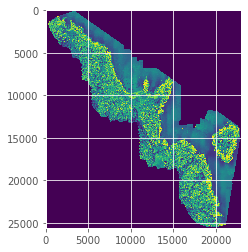

In [6]:
# Show RGB red band
with rasterio.open('../../frisk_oslofjord/raster/rgb/flight9_rgb_red.tif') as src:
    data = src.read(1)
    plt.imshow(data)

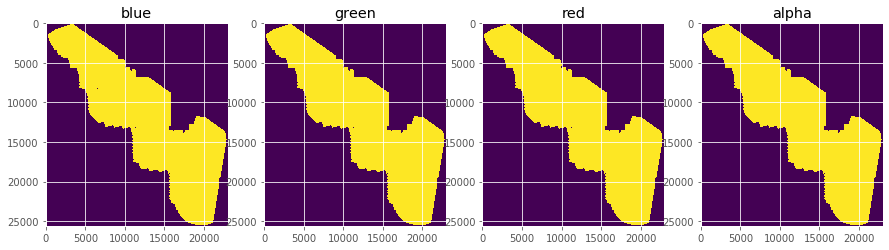

In [7]:
# Setup plot
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,6))

# Loop over images
for idx, fpath in enumerate(flist):
    name = os.path.split(fpath)[1].split('_')[-1][:-4]
    ds = rasterio.open(fpath)    
    data = ds.read(1)
    
    if name == 'alpha':
        axes[idx].imshow(data)
    else:
        axes[idx].imshow(data!=0)
        
    axes[idx].set_title(name)

The code above checks zeros in the three RGB colour bands against the alpha mask (which shows the true location of NoData pixels). It looks as though the value 0 could be used as NoData in these bands without any major issues, since there are only a few cells with values of zero *within* the alpha mask. 

Based on this, I suggest the following strategy for creating a combined dataset:

 * Discard the alpha mask from the RGB dataset. Use values of zero in these bands to indicate NoData
 
 * For the multispectral data, convert from 32-bit to 8-bit range by multiplying by 255 and rounding to the nearest integer. **Values of zero should be artificially set to one, and zero can then be used as the NoData value here as well**. This is a slight adjustment/fudge of the raw pixel values, but any effects on the subsequent inference process should be negligible

## 4. Build combined dataset

In [8]:
# List of all 5 cm images
flist = ['../../frisk_oslofjord/raster/rgb/flight9_rgb_red.tif',
         '../../frisk_oslofjord/raster/rgb/flight9_rgb_green.tif',
         '../../frisk_oslofjord/raster/rgb/flight9_rgb_blue.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_red.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_green.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_blue.tif',        
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_nir.tif',
         '../../frisk_oslofjord/raster/multi_spec/flight6_multispec_rededge.tif',
        ]

# Output
out_tif = '../../frisk_oslofjord/raster/ne_akeroya_5cm_all.tif'

# Read metadata of first file
with rasterio.open(flist[0]) as src:
    meta = src.meta

# Update meta to reflect the number of layers in output and NoData value
meta.update(count=len(flist), nodata=0)

# Read each layer and write it to stack
with rasterio.open(out_tif, 'w', **meta) as dst:
    for idx, fpath in enumerate(flist, start=1):
        # Get attributes from file name
        spec, name = os.path.split(fpath)[1].split('_')[1:]
        name = name[:-4]
        print('Processing:', spec, name)
        
        with rasterio.open(fpath) as src:
            # Read array
            data = src.read(1)
            
            if spec == 'multispec': # RGB data can be written directly
                # Set NoData and round
                data[data == -10000] = np.nan
                data = np.round(data*255, decimals=0)
                
                # Artificially adjust genuine zeros to ones
                data[data == 0] = 1
                
                # Set NoData as zero
                data[np.isnan(data)] = 0
                
                # Convert to uint8
                data = data.astype(np.uint8)
                
            # Save to output    
            dst.write_band(idx, data)                
                
            # Add band description
            dst.set_band_description(idx, f'{spec}_{name}')  

Processing: rgb red
Processing: rgb green
Processing: rgb blue
Processing: multispec red
Processing: multispec green
Processing: multispec blue
Processing: multispec nir
Processing: multispec rededge


## 5. Explore final dataset

The code below explores and checks the integrated dataset.

In [2]:
# Output path
out_tif = '../../frisk_oslofjord/raster/ne_akeroya_5cm_all.tif'

# Read downsampled version for better rendering speed
resamp_fac = 4

# Print dataset properties
with rasterio.open(out_tif) as src:
    band_titles = src.descriptions
    data = src.read(out_shape=(src.count, src.height // resamp_fac, src.width // resamp_fac),
                    resampling=Resampling.average)
    
    meta = src.meta
    for key in meta.keys():
        print(f'{key:10}:{meta[key]}')

driver    :GTiff
dtype     :uint8
nodata    :0.0
width     :23000
height    :25600
count     :8
crs       :PROJCS["ETRS_1989_UTM_Zone_32N",GEOGCS["GCS_ETRS_1989",DATUM["ETRS_1989",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
transform :| 0.05, 0.00, 607650.00|
| 0.00,-0.05, 6547960.00|
| 0.00, 0.00, 1.00|


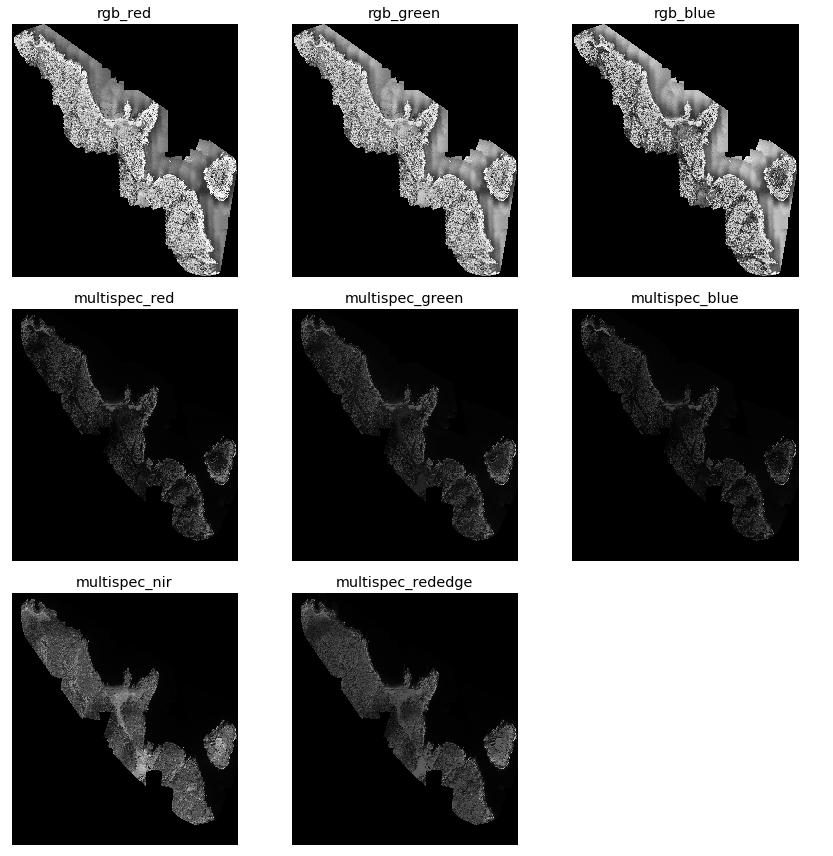

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c4c858908>,
      dtype=object)

In [3]:
# Plot all bands using earthpy
ep.plot_bands(data,
              title=band_titles, 
              cbar=False)

The multispectral data looks very dark compared to the RGB data. Let's take a look at histograms for each band.

(<Figure size 864x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c2fbc1048>,
       dtype=object))

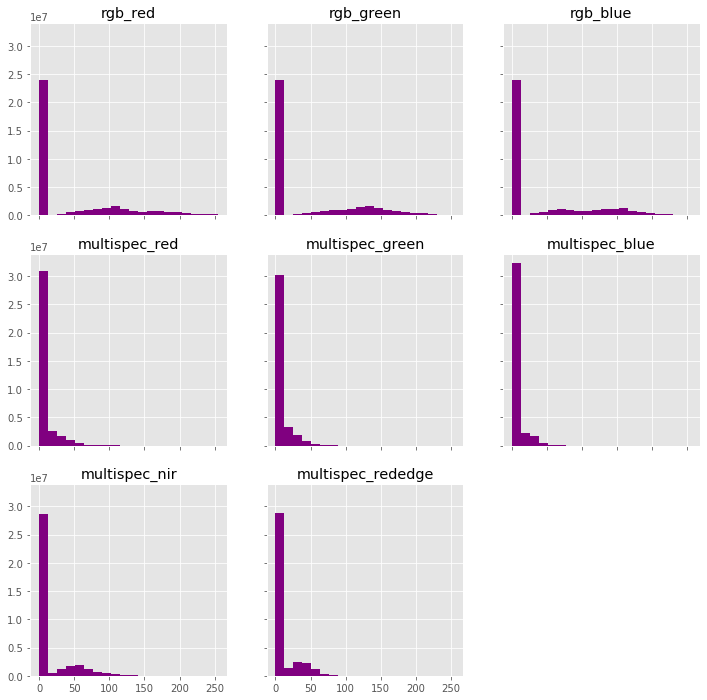

In [4]:
# Histograms of band values
ep.hist(data,
        cols=3,
        title=band_titles)

It is clear from the histograms above that the multispectral data is using only a small portion of the available range compared to the RGB data. Applying a "linear stretch" to these data should therefore give a better aesthetic appearance. **This might also help the ML algorithm - consider incorporating this change permanently?**

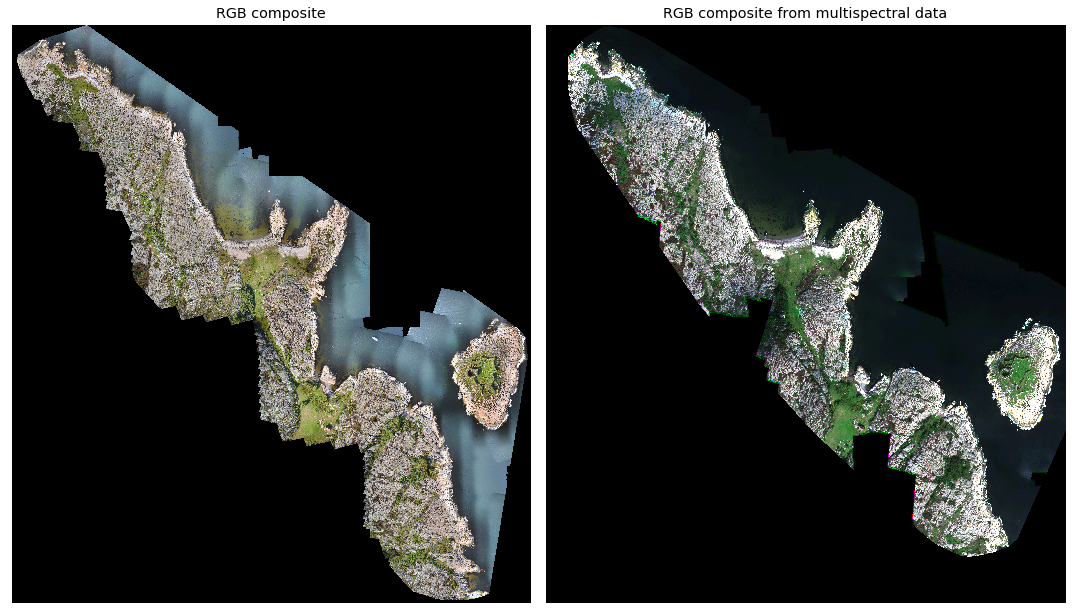

In [5]:
# Plot composite images
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,10))

ep.plot_rgb(data,
            rgb=[0, 1, 2],
            ax=axes[0],
            title="RGB composite")

ep.plot_rgb(data,
            rgb=[3, 4, 5],
            ax=axes[1],
            stretch=True, # Only needed for multispec
            title="RGB composite from multispectral data")

plt.tight_layout()